# Looking Back to Look Forward: Base Code

## 1. Introduction and Setup

This section imports the main script required for running the SIR and policy models.

In [21]:
# Import scripts

from lblf_SIR import SIRModel
from PolicySIR import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ema_workbench import (Model, RealParameter, ScalarOutcome, ema_logging, Constant)
from ema_workbench.em_framework import SequentialEvaluator
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume)
from ema_workbench.analysis import parcoords, prim, pairs_plotting, feature_scoring, dimensional_stacking
import pandas as pd
import seaborn as sns


## 2. Structural-Demographic Theory 

Structural-Demographic Theory (SDT) examines how socio-political stability and instability cycles occur in complex societies. These cycles are discussed in Turchin (2021), and are modelled using elements such as

- Mass Mobilization Potential (MMP): A measure of social pressures like income inequality and elite competition.
- Elite Overproduction: An increase in elites beyond what society can support, leading to heightened competition and instability.
- Youth Bulges: Larger-than-usual youth populations can increase instability by causing employment and social pressures.

These concepts are modeled here through a modified SIR approach, where susceptible individuals can become radicalized under adverse conditions and later moderated.



### Equations and Model Explanation

The SIR model is adapted for socio-political dynamics as follows:

- Susceptible (S): Non-radicalized individuals.
- Infected (I): Radicalized individuals.
- Recovered (R): Moderates who have transitioned from radicalization.

### Radicalization Rate (σ)
The radicalization rate is influenced by multiple factors, including a baseline rate $\sigma$. This baseline can be made dynamic (shown below) through the Political Stress Intex, but in the meantime

$$ \sigma = \sigma_0 + \left( \alpha - \gamma \cdot R_{\text{total}} \right) \cdot I_{\text{total}} $$

The parameter $\sigma$ represents the rate at which susceptible individuals become radicalized (i.e., enter the Infected state). It combines a baseline rate $\sigma_0$ with the radicalization potential $\alpha$, while moderates (i.e., individuals in $R$ reduce the rate).

The radicalization rate $\sigma$ s calculated in the simulate method of SIRModel as



In [ ]:
sigma = np.clip((alpha - self.gamma * np.sum(R[:, t])) * np.sum(I[:, t]) + self.sigma_0, 0, 1)

### Moderation Rate ($\rho$)

The moderation rate captures the rate at which radicalized individuals become moderates over time, with a delay factor $\tau$

$$ \rho = \delta \cdot \sum_{t-\tau} I $$

where:

$\delta$: Rate at which radicals become moderates.

$\tau$: Time delay for moderating radicalized individuals.


## 3. `lblf_SIR.py` - Implementation of the SIR Model

### Class Initialization and Parameters

The model is initialized with the following key parameters:

In [ ]:
class SIRModel:
    def __init__(self, pt_original=False, initialize_SIR=False, show_SIR_variation=True, enable_SDT=True, verbose=True):
    # Initialization and parameter setup
        self.T_ages = 45  # Number of age classes 
        self.sigma_0 = 0.0005  # Base spontaneous radicalization rate/fraction per year
        self.a_0 = 0.1  # Modulate down how many radicals form in the presence of radicals
        self.a_max = 1  # Maximum fraction of susceptibles that can radicalize
        self.gamma = 1  # Fraction of all recovered that influences conversion to radicals
        self.delta = 0.5  # Fraction of radicalized converting to moderate
        self.tau = 10  # Time delay for infected (radicalized) people to recover
        self.period_n = 1  # Number of periods to simulate
        self.I_0 = 0.1  # Initial fraction of infected
        self.R_0 = 0.0  # Initial fraction of recovered

The model includes several critical parameters that influence the dynamics of radicalization and moderation within the population:

- Radicalization Controls ($a_0$, $a_{\text{max}}$, and $\sigma_0$): These parameters determine the baseline and potential range of the radicalization rate. They allow the model to account for the influence of societal pressures on individuals’ likelihood of becoming radicalized. The base radicalization rate, $\sigma_0$, represents the spontaneous rate of radicalization in a stable environment, while $a_0$ and $a_{\text{max}}$ set limits on how much this rate can increase under changing social or economic conditions.

- Moderation Controls ($\gamma$ and $\delta$): These parameters control the rate at which radicalized individuals transition back to moderate states, thus helping to stabilize the population. $\gamma$ represents the influence of moderate individuals on reducing radicalization across the population, while $\delta$ governs the direct rate of transition from radicalized to moderate states, simulating the recovery or stabilization effect that moderates have on the society.

- Time Delay ($\tau$): This parameter introduces a lag in the moderation effect, reflecting the fact that it takes time for radicalized individuals to reintegrate into moderate society. This delay simulates the real-world inertia in societal adjustments to instability, where social recovery often lags behind initial radicalization triggers.

### Simulation Process 

In each time step, the model updates the population for each group as follows:

1. Susceptible ($S$) Transition: The number of susceptible individuals in the next age group is reduced by those who become radicalized (i.e., enter the Infected state) at time $t$ with a rate $\sigma$.

$$ S_{\text{age}+1}(t+1) = (1 - \sigma) \cdot S_{\text{age}}(t) $$

2. Infected ($I$) Transition: The number of infected individuals (radicalized) is updated by adding the portion of susceptibles who became radicalized at time $t$ and reducing by those who recover (i.e., become moderates) at a rate $\rho$.

$$ I_{\text{age}+1}(t+1) = (1 - \rho) \cdot I_{\text{age}}(t) + \sigma \cdot S_{\text{age}}(t) $$

3. Recovered ($R$) Transition: The number of recovered (moderate) individuals is updated by adding those who recover from radicalization (i.e., leave the Infected state) at time $t$.

$$ R_{\text{age}+1}(t+1) = R_{\text{age}}(t) + \rho \cdot I_{\text{age}}(t) $$

The Susceptible population decreases due to radicalization, which is controlled by the rate $\sigma$.
The Infected population increases due to new radicalizations from the Susceptible group and decreases due to moderation (controlled by $\rho$).
The Recovered population increases as individuals moderate from the Infected group.

These transitions are implemented in the code as follows: 

In [ ]:
for age in range(self.T_ages - 1):
    S[age+1, t+1] = (1 - sigma) * S[age, t]
    I[age+1, t+1] = (1 - rho) * I[age, t] + sigma * S[age, t]
    R[age+1, t+1] = R[age, t] + rho * I[age, t]

This allows the model to simulate the flow of individuals across different states over time, taking into account the influence of radicalization and moderation rates. 

### Political Stress Index

The Political Stress Index (PSI) is a composite measure that reflects the overall socio-political stress within a society. In Structural-Demographic Theory (SDT), PSI typically encompasses factors like elite competition, economic hardship, and social immiseration, all of which can impact radicalization and moderation rates in the model. Higher PSI values indicate greater socio-political strain, increasing the likelihood of instability and potential radicalization.

The PSI can be calculated as a weighted sum or product of several socio-economic factors, such as relative income, elite overproduction, and demographic pressures (e.g., a youth bulges). For this model, we assume a high PSI corresponds with high socio-political strain, which can trigger periods of instability.

$$ \alpha(t) = \alpha_0 + \alpha_w (w_0 - w) + \alpha_e (e - e_0) + A_{20} $$

In this equation, $\alpha_0$ represents the baseline radicalization potential, while $\alpha_w$ denotes the sensitivity of the radicalization potential to changes in relative income, $w$. The term $w_0$ is the expected or baseline relative income level, and $w$ is the current relative income. Similarly, $\alpha_e$ represents the sensitivity of the radicalization potential to changes in the elite fraction, $e$, with $e_0$ as the expected or baseline elite fraction. Finally, $A_{20}$ is an additional demographic term, which may account for the effect of a youth bulge or other demographic factors on radicalization.

This equation allows the radicalization potential $\alpha(t)$ to adjust dynamically based on changes in socio-economic factors, aligning with Turchin's Structural-Demographic Theory. 

### Running the Code

Once `lblf_SIR.py` is imported, the model can be run using the following lines

1810-1840: 30 years 0.0%
1840-1850: 10 years -1.5%
1850-1910: 60 years 0.0%
1910-1940: 30 years 0.5%
1940-1970: 30 years 0.0%
1970-2000: 30 years -0.5%
2000-2020: 20 years 0.0%
2020-2025: 5 years 3.0%
2025-2100: 75 years 0.0%


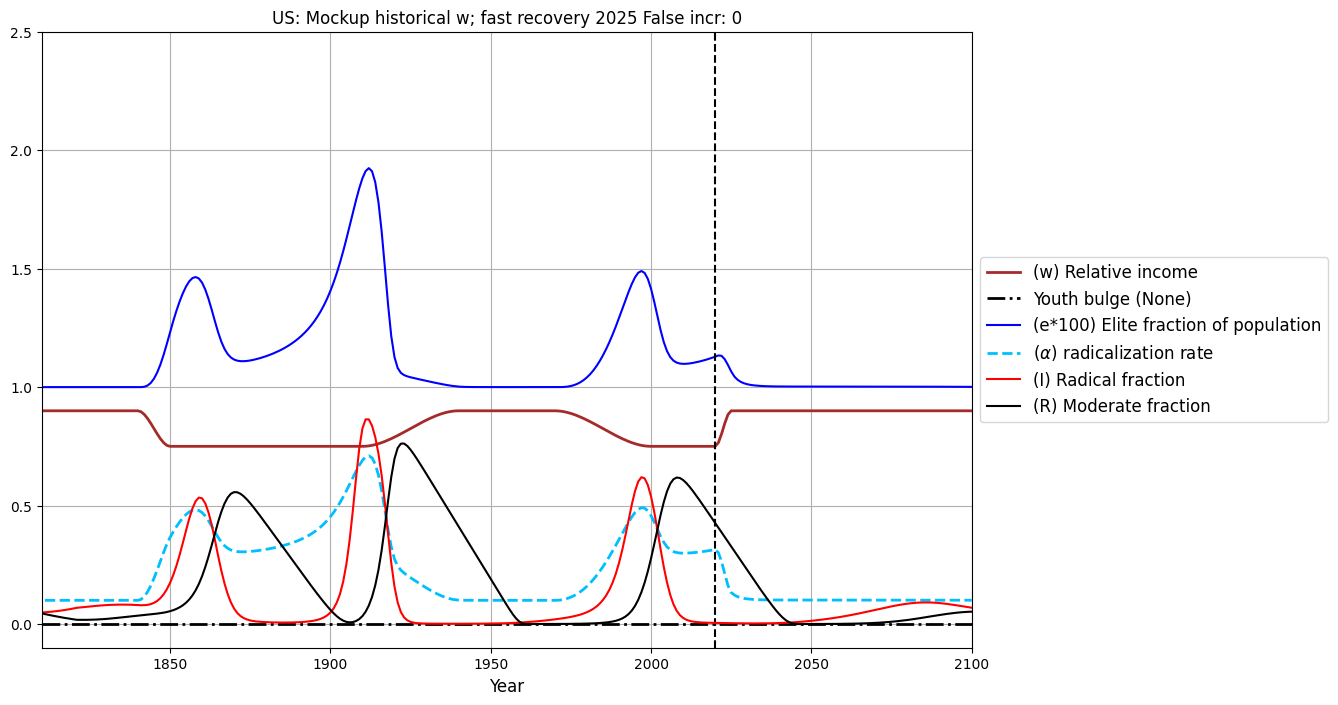

In [4]:
model = SIRModel(initialize_SIR=False, show_SIR_variation=False, enable_SDT=True)
model.run_model()
model.plot_results()


### Cunterfactuals and Shocks 

The `compare_with_shock` method is designed to simulate the effects of an abrupt "shock" to the system by modifying either wage levels or elite numbers. This approach allows  to investigate how sudden, hypothetical changes might impact the socio-political dynamics represented in the model. By introducing a shock, such as an unexpected decrease in wages or a rapid increase in the elite population, this method can simulate counterfactual scenarios. These scenarios provide insights into how the system might behave under conditions that deviate from the baseline, helping to reveal its inherent resilience or susceptibility to destabilizing events.

To model the shock, the method alters the wage level from its baseline value, $w(t)$, to a new, shocked value, $w'(t)$:

$$ w'(t) = w(t) + \Delta w $$

where $\Delta w$ represents the magnitude of the shock applied to the wage level at time $t$.

The implementation is the same as the basic simulation, but with the shock added. To run a counterfactual, the following lines can be used 


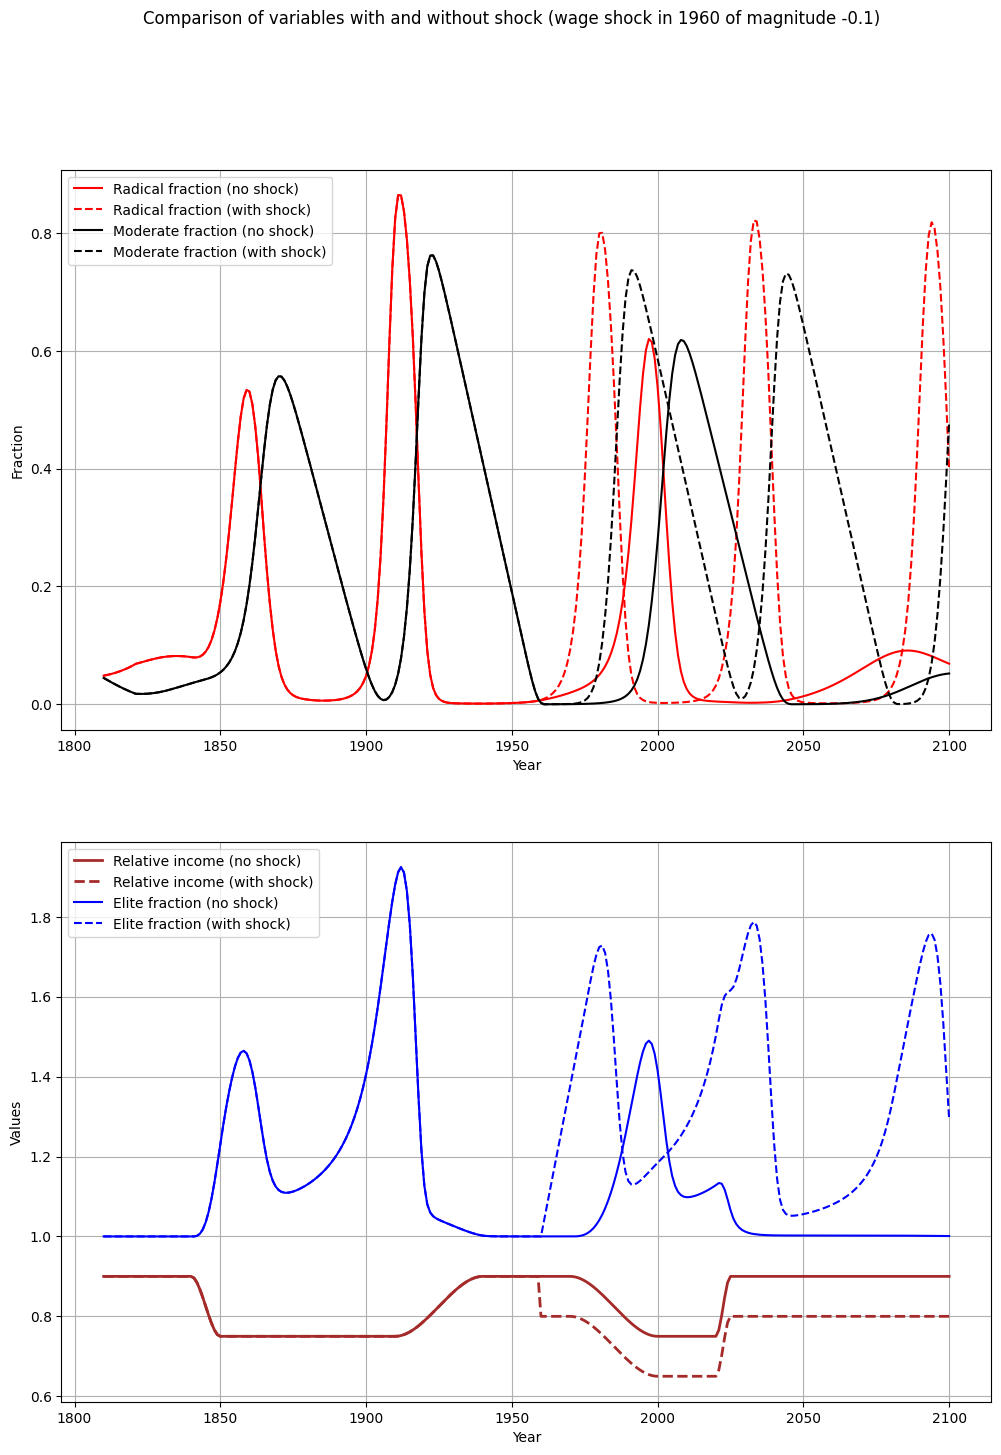

In [5]:
shock_type = 'wage'  # or 'elite'
shock_year = 1960
shock_magnitude = -0.1
model.compare_with_shock(shock_type, shock_year, shock_magnitude)

## 4. `policySIR.py` - Adding Policy Adjustments

The PolicySIRModel extends the basic SIR model by introducing policy adjustments that aim to influence the wage level and control radicalization rates. Through these interventions, the model simulates the potential effects of policies on socio-political stability, exploring how well the system can be stabilized by managing economic and social variables.

In the PolicySIRModel, the adjustment to the wage level, denoted $\Delta w(t)$, is calculated based on two main objectives: reaching a target wage level and managing radicalization levels across different age groups. The equation for $\Delta w(t)$ is:

$$\Delta w(t) = \eta_w \cdot \max(w_T - w(t), 0) + \sum_{a=1}^{T_{\text{ages}}} \eta_{a} \cdot \max(I_a(t) - I_{T_a}, 0) $$

This equation has two terms. The first term represents an income target adjustment, which is applied when the current wage $w(t)$ falls below the target wage $w_T$. The factor $\eta_w$ controls the sensitivity of this adjustment, determining how strongly the policy responds to the difference between $w(t)$ and $w_T$. By increasing $w(t)$ toward $w_T$, this adjustment aims to maintain economic stability, potentially reducing the likelihood of social unrest.

The second term of the equation is a radicalization control adjustment that responds to radicalization levels across age groups. Here, $\eta_{a}$ is a sensitivity factor that varies by age group, indicating how strongly the policy should respond if radicalization in a particular cohort, $I_a(t)$, exceeds the target level $I_{T_a}$. This control mechanism allows the policy to be more adaptive, applying greater pressure to reduce radicalization in specific age groups as needed.

This is implemented in the `PolicySIRModel` class, which adds the new parameters

In [ ]:
class PolicySIRModel(SIRModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.eta_w, self.eta_a = 0.0, np.zeros(self.T_ages)
        self.w_T, self.I_Ta = 0.0, np.zeros(self.T_ages)

The simulate method is also modified to apply policy interventions as adjustments to wage levels


In [ ]:
def simulate(self, S0, I0, R0, w):
    for t in range(len(self.period) - 1):
        delta_w_t = self.eta_w * max(self.w_T - w[t], 0) + np.sum(self.eta_a * np.maximum(I[:, t] - self.I_Ta, 0))
        w[t] += delta_w_t  # Policy-adjusted wage level

The PolicySIRModel provides three primary outputs 

- Maximum Radicalized Fraction ($I_{\text{max}}$): This output represents the highest percentage of the population that becomes radicalized at any point during the simulation. For example, if $I_{\text{max}} = 0.25$, it means that at the peak, 25% of the population was in a radicalized state. This measure helps policymakers understand the potential severity of radicalization under certain conditions. A high $I_{\text{max}}$ could indicate a system under significant stress, suggesting that additional or more aggressive policies might be necessary to prevent widespread unrest.

- Final Radicalized Fraction ($I_{\text{final}}$): This is the proportion of the population that remains radicalized by the end of the simulation period. For instance, if $I_{\text{final}} = 0.05$, then 5% of the population is still radicalized after all policy interventions have been applied. This output gives a sense of the long-term effectiveness of the policies; ideally, $I_{\text{final}}$ would be low, showing that the interventions successfully reduced radicalization to manageable levels. A high $I_{\text{final}}$ would suggest that the policies had limited impact, leaving a sizable portion of the population radicalized and possibly indicating lingering socio-political instability.

- Policy Cost: The PolicySIRModel also calculates the cumulative cost of the interventions applied to stabilize the system. Each time a policy adjustment is made to bring the wage closer to the target level or to keep radicalization levels within acceptable limits, this adjustment adds to the policy_cost. For instance, if policy_cost = 10.0, this total cost reflects the extent of resources or effort required to maintain stability over the course of the simulation. Policymakers can use this output to assess the economic feasibility of the interventions. If the cost is too high relative to the achieved stability (e.g., if $I_{\text{final}}$ remains high despite a significant policy cost), it may suggest that the policies need to be recalibrated for efficiency.

## 5. Exploring Levers and Uncertainties Using the EMA Workbench

Now that the policy SIR is loaded, it is possible to explore the implications of uncertainties and levers on the three policy outcomes, namely Maximum Radicalized Fraction, Final Radicalized Fraction and Policy Cost

### Model Definition

The PolicySIRModel is defined in EMA Workbench with `ema_model = Model('PolicySIR', function=policySIRModel)`. The `function=policySIRModel` links the model to its code implementation.

### Uncertainties

Uncertainties: We specify uncertainties using `RealParameter` to allow exploration of possible parameter values. Here, a_w (affecting wage) varies between 0.5 and 1.5, and a_e (affecting elites) ranges from 25.0 to 75.0. These parameters introduce variability, simulating real-world unpredictability in wage and elite dynamics.

### Policy Levers

The policy levers control aspects of the model that can be adjusted through interventions. 

- eta_w and eta_a: These control wage adjustments and sensitivity to radicalization across age groups, respectively.
- w_T and I_Ta: These are target levels for wage and acceptable radicalization levels within cohorts, guiding how strongly the policy aims to stabilize the system.

### Outcomes

The model outcomes represent the primary metrics for evaluating policy success. In this case:

- max_radicalized: The peak radicalization rate during the simulation.
- final_radicalized: The radicalization level at the end of the simulation.
- policy_cost: The cumulative cost of implementing the policy interventions.

In [16]:
ema_model = Model('PolicySIR', function= policySIRModel)

# Uncertainties 
ema_model.uncertainties = [
    RealParameter('a_w', 0.5, 1.5),
    RealParameter('a_e', 25.0, 75.0)
 ]

# levers
ema_model.levers = [
    RealParameter('eta_w', 0.0, 1.0),
    RealParameter('eta_a', 0.0, 1.0),  # Assuming same eta_a for all ages
    RealParameter('w_T', 0.8, 1.0),
    RealParameter('I_Ta', 0.0, 0.1),  # Assuming same I_Ta for all ages
]

# Outcomes
ema_model.outcomes = [
    ScalarOutcome('max_radicalized'),
    ScalarOutcome('final_radicalized'), 
    ScalarOutcome('policy_cost') 
]

# Use SequentialEvaluator
with SequentialEvaluator(ema_model) as evaluator:
    results_uncertainty = evaluator.perform_experiments(scenarios=1000, policies=10)

100%|████████████████████████████████████| 10000/10000 [07:05<00:00, 23.51it/s]


In [17]:
# Analyze and visualize the uncertainty results
experiments_unc, outcomes_unc = results_uncertainty
results_unc_df = pd.DataFrame.from_dict(experiments_unc)
outcomes_unc_df = pd.DataFrame.from_dict(outcomes_unc)
uncertainty_df = pd.concat([results_unc_df, outcomes_unc_df], axis=1)

### Analyzing Results

The parallel coordinates plot visualizes the relationship between uncertainties, policy levers, and model outcomes. Below four methods are showcased and their results briefly discussed

#### Parallel Coordinates Plot

The parallel coordinates plot visualizes the relationship between uncertainties, policy levers, and model outcomes. This plot shows each experiment as a line, highlighting which combinations of parameters yield lower max_radicalized values. By overlaying top-performing experiments in different colors, we can identify parameter ranges that lead to favorable outcomes.

 10%|███▋                                 | 100/1000 [32:43<4:54:32, 19.64s/it]


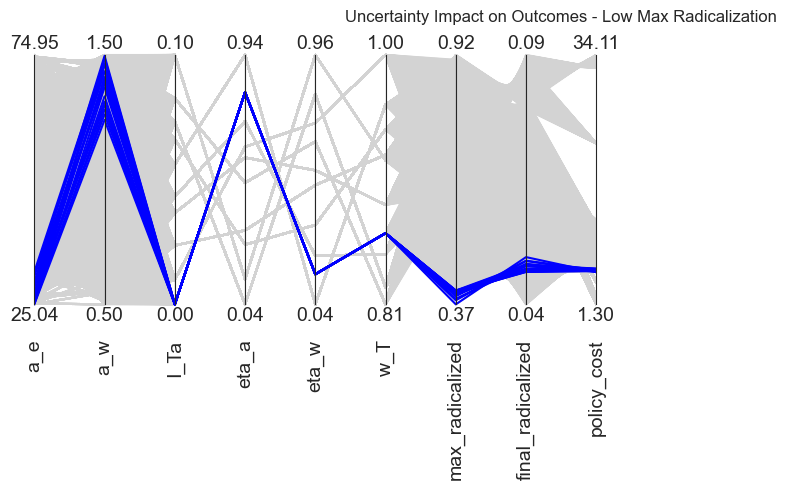

In [18]:
uncertainty_df_numeric = uncertainty_df.select_dtypes(include=[float, int])

top_lowest_radicalized = uncertainty_df_numeric.nsmallest(20, 'max_radicalized')

# Parallel Coords Plot
parcoords_lims = parcoords.get_limits(uncertainty_df_numeric)
paraxes_unc = parcoords.ParallelAxes(parcoords_lims)

# Plot all lines in light gray
paraxes_unc.plot(uncertainty_df_numeric, color='lightgray')

# Overlay the top 20 lines with the lowest 'max_radicalized' in blue
paraxes_unc.plot(top_lowest_radicalized, color='blue')

# Set plot title
plt.title('Uncertainty Impact on Outcomes - Low Max Radicalization')
plt.show()

The same can be done for cost minimization. For example

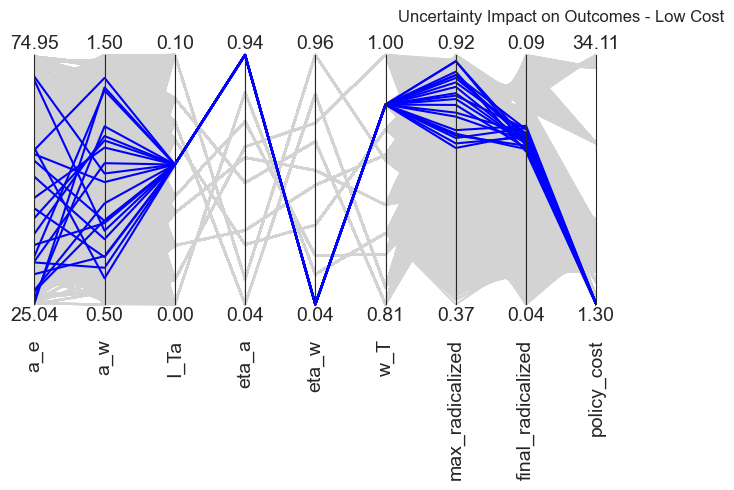

In [19]:
top_lowest_cost = uncertainty_df_numeric.nsmallest(20, 'policy_cost')

# Parallel Coords Plot
parcoords_lims = parcoords.get_limits(uncertainty_df_numeric)
paraxes_unc = parcoords.ParallelAxes(parcoords_lims)

# Plot all lines in light gray
paraxes_unc.plot(uncertainty_df_numeric, color='lightgray')

# Overlay the top 20 lines with the lowest 'policy_cost' in blue
paraxes_unc.plot(top_lowest_cost, color='blue')

# Set plot title
plt.title('Uncertainty Impact on Outcomes - Low Cost')
plt.show()

Both plots suggest that higher values of a_w (sensitivity to wage changes) and eta_w (wage adjustment) are crucial for achieving desirable outcomes. When these parameters are set high, the model is more successful in both reducing radicalization (both peak and final levels) and keeping policy costs manageable. This implies that policies focused on wage adjustments that react quickly and strongly to economic discrepancies may be effective in managing radicalization in the long term, providing a pathway for both stability and cost-efficiency.

#### PRIM (Patient Rule Induction Method)

PRIM is used to identify conditions (parameter ranges) associated with favorable outcomes, here defined as max_radicalized below a threshold (e.g., 0.8). The PRIM trade-off plot shows the relationship between coverage (how much of the dataset meets the conditions) and density (how strongly the conditions are associated with favorable outcomes). By inspecting specific PRIM boxes, we can understand which parameter combinations are most likely to reduce radicalization effectively.



[MainProcess/INFO] 10000 points remaining, containing 3714 cases of interest
[MainProcess/INFO] mean: 0.9988719684151156, mass: 0.1773, coverage: 0.47684437264404955, density: 0.9988719684151156 restricted_dimensions: 3


coverage       0.988153
density        0.386316
id             1.000000
k           3670.000000
mass           0.950000
mean           0.386316
n           9500.000000
res_dim        1.000000
Name: 1, dtype: float64

         box 1                              
           min        max qp value  qp value
a_e  25.040004  72.507175      NaN  0.001389



[None]

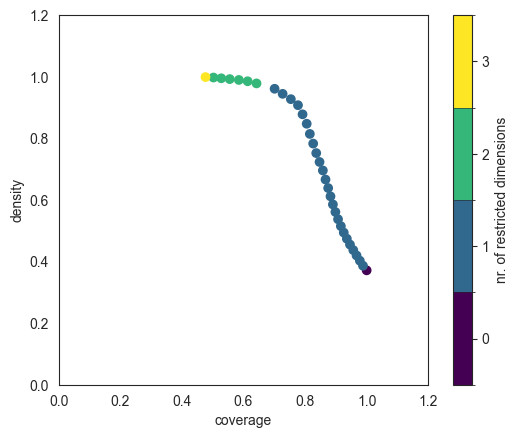

In [25]:
x = uncertainty_df_numeric.drop(columns=['max_radicalized', 'final_radicalized', 'policy_cost'])  # Use only input parameters
y = uncertainty_df_numeric['max_radicalized'] < 0.8  # Define y based on threshold for max_radicalized outcome

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

# Display the results
box1.show_tradeoff()
box1.inspect(1, style='table')  # Inspecting the first box


Box 22 represents a parameter space where elite sensitivity (a_e) is kept between 25.04 and 40.92. This box achieves a high density (90.8%) of favorable outcomes, suggesting that keeping a_e within this range is a significant factor in reducing radicalization or achieving other desired results in the model. With a coverage of 77.7%, Box 22 applies to a large portion of scenarios, making it a broadly applicable and effective configuration in this context.

coverage       0.777060
density        0.907547
id            22.000000
k           2886.000000
mass           0.318000
mean           0.907547
n           3180.000000
res_dim        1.000000
Name: 22, dtype: float64

        box 22                             
           min        max qp value qp value
a_e  25.040004  40.922495      NaN      0.0



[<Figure size 640x480 with 1 Axes>]

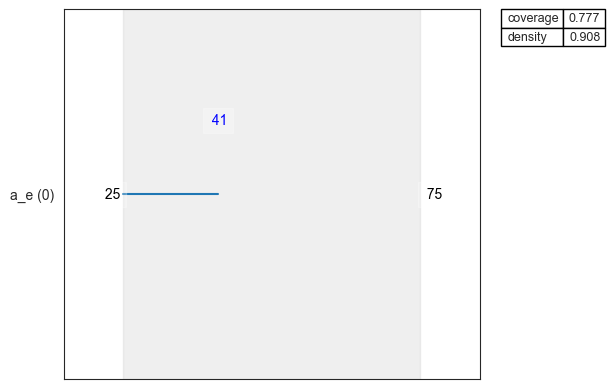

In [26]:
box1.inspect(22)
box1.inspect(22, style="graph")

#### Feature Scoring

Feature scoring quantifies the importance of each parameter in determining the outcomes. The results are displayed as a heatmap. The heatmap highlights which parameters have the greatest impact on outcomes like max_radicalized, final_radicalized, and policy_cost. For example, if w_T has high scores across all outcomes, it indicates that setting wage targets is critical to managing both radicalization and policy costs.

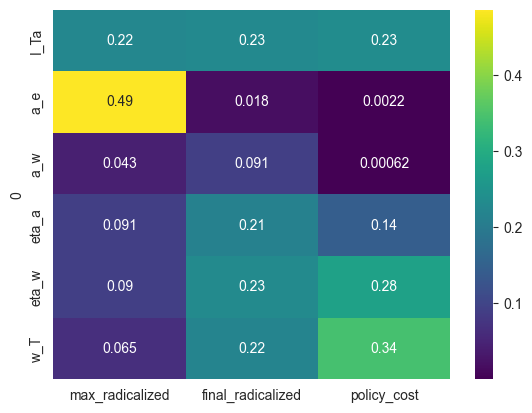

In [27]:
outcome_columns = ['max_radicalized', 'final_radicalized', 'policy_cost']

x = uncertainty_df_numeric.drop(columns = outcome_columns) 
y = {col: uncertainty_df_numeric[col] for col in outcome_columns}


fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

The heatmap shows that a_e (elite sensitivity) is the most critical factor in controlling peak radicalization (max_radicalized), meaning that changes in the elite population's influence strongly impact the maximum radicalization level. For managing long-term radicalization (final_radicalized) and policy expenses (policy_cost), the key factors are eta_a (radicalization adjustment sensitivity), eta_w (wage adjustment sensitivity), and w_T (target wage level). This suggests that both targeted radicalization control and wage-related policies are essential for sustained stability and cost management. Of these, w_T has the greatest impact on policy_cost, implying that setting an appropriate wage target is crucial for keeping intervention costs manageable. If the target wage level (w_T) is too high, policy costs will likely increase as the model works harder to meet this target. Overall, effective policy planning to reduce radicalization peaks, ensure long-term stability, and control expenses should focus on these influential parameters, particularly elite sensitivity for peak radicalization and wage adjustments for cost efficiency

#### Dimensional Stacking

Dimensional stacking provides a way to visualize multidimensional data by creating a “stacked” representation of parameter ranges, using a threshold for max_radicalized. This plot categorizes combinations of uncertainties and levers into bins, showing which configurations fall below the radicalization threshold. By highlighting favorable regions, dimensional stacking helps identify robust policy settings that consistently achieve low radicalization.

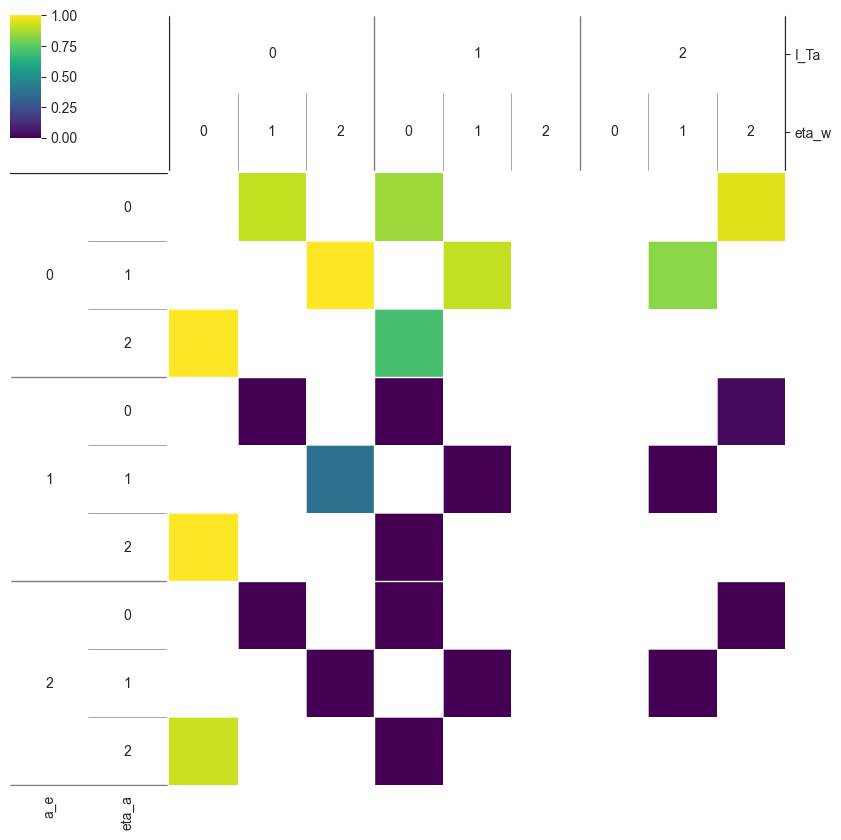

In [42]:
x = uncertainty_df_numeric.drop(columns=['max_radicalized', 'final_radicalized', 'policy_cost'])
y = uncertainty_df_numeric['max_radicalized'] < 0.8   # Define the condition for dimensional stacking

y_array = y.values  # Converts the Series to a numpy array

# Create the dimensional stacking plot with y as a numpy array
dimensional_stacking.create_pivot_plot(x, y_array, 2, nbins = 3)
plt.show()

The values of a_e (elite sensitivity) and eta_a (radicalization adjustment sensitivity) show a strong influence on the outcomes. Cells where both a_e and eta_a are at high values (e.g., 2) tend to be darker, indicating less favorable outcomes. This suggests that high sensitivity in both elite factors and radicalization adjustments may lead to increased instability or higher radicalization, as indicated by the darker color.

It should also be mentioned that for I_Ta (radicalization target level) and eta_w (wage adjustment sensitivity), a similar trend can be observed. Higher values of eta_w tend to show lighter cells, particularly when I_Ta is also moderate or high, indicating that high wage adjustment sensitivity generally improves outcomes.

## 6. Conclusions

The overall conclusion drawn from these plots is that the PolicySIRModel outcomes—specifically the reduction of radicalization and management of policy costs—are highly sensitive to certain key parameters, particularly elite sensitivity (a_e), radicalization adjustment sensitivity (eta_a), and wage adjustment sensitivity (eta_w).

The analysis suggests that keeping elite sensitivity (a_e) at moderate levels helps control radicalization without destabilizing the system. High values of a_e tend to increase peak radicalization, which implies that excessive influence from elite-related dynamics can lead to greater instability. In terms of radicalization adjustment sensitivity (eta_a), moderate adjustments yield better long-term stability. High values of eta_a can lead to unintended consequences, such as an increase in radicalization, due to overly aggressive interventions. Therefore, a careful, measured approach to adjusting radicalization levels within cohorts appears to result in more favorable outcomes.

A high wage adjustment sensitivity (eta_w) ahowcases how the model can swiftly respond to economic imbalances, effectively managing both radicalization levels and policy costs. Strong wage adjustments are shown to help stabilize the system by addressing underlying economic drivers of radicalization. Lastly, setting realistic radicalization targets (I_Ta) further supports stability, especially when combined with effective wage adjustments. Lower target radicalization levels are associated with more favorable outcomes when paired with policies that also focus on economic adjustments. Overall, the optimal strategy is to avoid extremes—particularly high elite sensitivity or aggressive radicalization adjustments—while ensuring strong economic support through wage adjustments and setting achievable radicalization targets. This balanced approach helps maintain socio-political stability effectively and economically.



## References

Turchin, P. (2021). *Multipath Forecasting: the Aftermath of the 2020 American Crisis*. Complexity Science Hub Vienna, March 5, 2021.